In [1]:
import numpy as np
import Scripts.cifar_resnet as rn
import Scripts.wake_processing as wp
import importlib
import Scripts.autoencoder as ae
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
%matplotlib inline

In [2]:
importlib.reload(rn)
importlib.reload(wp)

<module 'Scripts.wake_processing' from 'E:\\Studies\\Deep Water\\DeepWater\\Scripts\\wake_processing.py'>

## Training Data

In [3]:
real_wakes = np.load("Data\\Wake data\\confirmed_wakes.npy")
generated_wakes = np.load("Data\\Wake data\\generated_wakes.npy")
not_wakes = np.load("Data\\Wake data\\negative_day_samples.npy")

real_wakes = real_wakes[:,:,:-1,:]
not_wakes = not_wakes[:,:,:-1,:]
train_real, test_real = train_test_split(real_wakes, test_size=0.2, random_state=4)
train_gen, test_gen = train_test_split(generated_wakes, test_size=0.08, random_state=4)
train_neg, test_neg = train_test_split(not_wakes, test_size = 0.06, random_state = 4)
test_pos = np.append(test_real, test_gen, axis = 0)
train_pos = np.append(train_real, train_gen, axis = 0)
test_x = np.append(test_pos, test_neg, axis = 0)
train_x = np.append(train_pos, train_neg, axis = 0)
test_pos_y = np.concatenate((np.ones(test_pos.shape[0]).reshape(-1,1), np.zeros(test_pos.shape[0]).reshape(-1,1)), axis = 1)
test_neg_y = np.concatenate((np.zeros(test_neg.shape[0]).reshape(-1,1), np.ones(test_neg.shape[0]).reshape(-1,1)), axis = 1)
train_pos_y = np.concatenate((np.ones(train_pos.shape[0]).reshape(-1,1), np.zeros(train_pos.shape[0]).reshape(-1,1)), axis = 1)
train_neg_y = np.concatenate((np.zeros(train_neg.shape[0]).reshape(-1,1), np.ones(train_neg.shape[0]).reshape(-1,1)), axis = 1)
test_y = np.append(test_pos_y, test_neg_y, axis = 0)
train_y = np.append(train_pos_y, train_neg_y, axis = 0)

In [4]:
train_dataset = TensorDataset(torch.Tensor(train_x), torch.Tensor(train_y))
test_dataset = TensorDataset(torch.Tensor(test_x), torch.Tensor(test_y))

In [5]:
test_dataset.tensors[0].shape

torch.Size([118, 4, 28, 60])

In [6]:
test_dataset.tensors[1].shape

torch.Size([118, 2])

## Train function

In [7]:
def train_rn(model, train_data, test_data, num_epochs=5, batch_size=5, learning_rate=1e-3):
    model = model.to(device)
    torch.manual_seed(0)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=0, drop_last=True)
    X_val, y_val = test_data.tensors[0].to(device), test_data.tensors[1].to(device)
    train_losses = []
    val_losses = []
    val_accs = []
    train_accs= []
    for epoch in range(num_epochs):
        total_loss = []
        batch_accs = []
        for i, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_pred_label = 1 - torch.argmax(pred, dim = 1).cpu().detach().numpy()
            train_true_label = 1 - torch.argmax(y, dim = 1).cpu().detach().numpy()
            batch_acc = accuracy_score(train_true_label, train_pred_label)
            batch_accs.append(batch_acc)
            total_loss.append(loss.item())
            
        val_pred = model(X_val)
        val_pred_label = 1 - torch.argmax(val_pred, dim = 1).cpu().detach().numpy()
        val_true_label = 1 - torch.argmax(y_val, dim = 1).cpu().detach().numpy()
        val_loss = criterion(val_pred, y_val).item()
        train_loss = sum(total_loss)/len(total_loss)
        train_acc = sum(batch_accs)/len(batch_accs)
        val_acc = accuracy_score(val_true_label, val_pred_label)
        print('Epoch:{}, Loss:{:.4f}, Val Loss:{:.4f}, Train Acc:{:4f}, Val Acc:{:.4f}'.format(epoch+1, train_loss,
                                                                                               val_loss, train_acc, val_acc))
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        train_accs.append(train_acc)
    return train_losses, val_losses, train_accs, val_accs

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Training with limited epochs

In [11]:
resnet = None
resnet = rn.ResNet18()
train_losses, val_losses, train_accs, val_accs = train_rn(resnet, train_dataset, test_dataset, num_epochs = 15, learning_rate=1e-4)

Epoch:1, Loss:0.2783, Val Loss:0.2563, Train Acc:0.884058, Val Acc:0.9153
Epoch:2, Loss:0.1395, Val Loss:0.3438, Train Acc:0.955072, Val Acc:0.8983
Epoch:3, Loss:0.0864, Val Loss:0.3357, Train Acc:0.972464, Val Acc:0.9068
Epoch:4, Loss:0.0635, Val Loss:0.2578, Train Acc:0.977536, Val Acc:0.9407
Epoch:5, Loss:0.0458, Val Loss:0.2622, Train Acc:0.984783, Val Acc:0.9322
Epoch:6, Loss:0.0500, Val Loss:0.3942, Train Acc:0.984058, Val Acc:0.8983
Epoch:7, Loss:0.0354, Val Loss:0.7319, Train Acc:0.986957, Val Acc:0.8220
Epoch:8, Loss:0.0250, Val Loss:0.2983, Train Acc:0.992754, Val Acc:0.9492
Epoch:9, Loss:0.0031, Val Loss:0.8703, Train Acc:1.000000, Val Acc:0.8220
Epoch:10, Loss:0.0149, Val Loss:0.4461, Train Acc:0.997101, Val Acc:0.9068
Epoch:11, Loss:0.0016, Val Loss:0.4007, Train Acc:1.000000, Val Acc:0.9322
Epoch:12, Loss:0.0005, Val Loss:0.4577, Train Acc:1.000000, Val Acc:0.9153
Epoch:13, Loss:0.0005, Val Loss:0.4664, Train Acc:1.000000, Val Acc:0.9237
Epoch:14, Loss:0.0004, Val Loss:0.

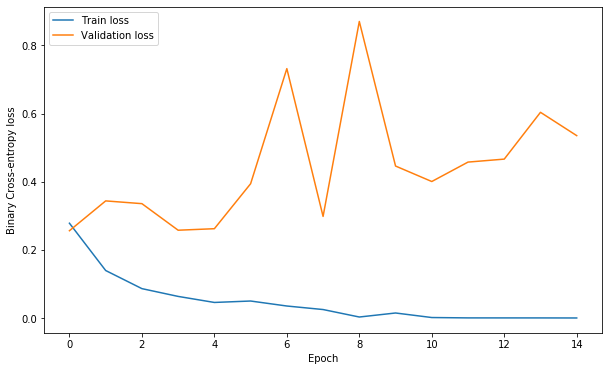

In [12]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label = 'Train loss')
plt.plot(val_losses, label = 'Validation loss')
plt.legend(loc = 'upper left')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-entropy loss')
plt.show()

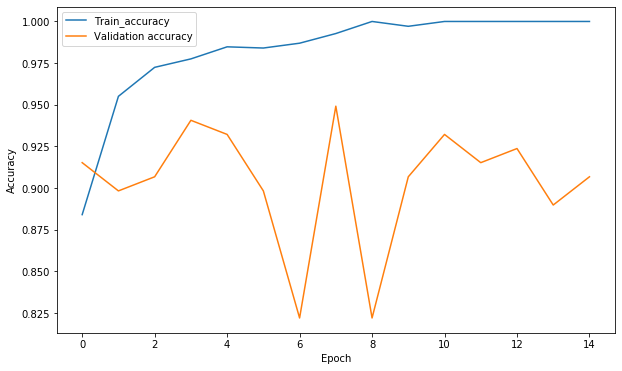

In [13]:
plt.figure(figsize=(10,6))
plt.plot(train_accs, label = 'Train accuracy')
plt.plot(val_accs, label = 'Validation accuracy')
plt.legend(loc = 'upper left')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

## Passing Full Training Dataset

In [14]:
data_series = wp.get_files()
cutoff = np.where(data_series[0,-2]<wp.date_to_stamp([9, 22, 0, 0]))[0][-1]
train_series = data_series[:,:,:cutoff]
test_series = data_series[:,:,cutoff:]

In [155]:
predictions = []
for i in tqdm(range((train_series.shape[2] - 60))):
    if train_series[0, -1, i] == 1:
        time = train_series[0, -2, i]
        next_frame = torch.from_numpy(train_series[:,:-2,i:i+60]).float().unsqueeze(0).to(device)
        label = int(torch.argmax(resnet(next_frame), dim = 1).cpu().detach())
        predictions.append(np.array([time, label]))
predictions = np.array(predictions)

100%|███████████████████████████████████████████████████████████████████████████| 69122/69122 [09:18<00:00, 123.79it/s]


In [191]:
predictions_day_night = []
for i in tqdm(range((train_series.shape[2] - 60))):
    time = train_series[0, -2, i]
    next_frame = torch.from_numpy(train_series[:,:-2,i:i+60]).float().unsqueeze(0).to(device)
    label = int(torch.argmax(resnet(next_frame), dim = 1).cpu().detach())
    predictions_day_night.append(np.array([time, label]))     
predictions_day_night = np.array(predictions_day_night)

100%|████████████████████████████████████████████████████████████████████████████| 69122/69122 [28:49<00:00, 39.96it/s]


In [199]:
predicted_ws_day = predictions[np.where(predictions[:,1] == 0)][:,0]
predicted_ws_day_night = predictions_day_night[np.where(predictions_day_night[:,1] == 0)][:,0]

In [201]:
unknown_wakes_day = predicted_ws_day
for ws in new_ws:
    unknown_wakes_day = unknown_wakes_day[np.where((ws-1800 >= unknown_wakes_day) | (unknown_wakes_day  >= ws+1800))]

In [202]:
unknown_wakes_day_night = predicted_ws_day_night
for ws in new_ws:
    unknown_wakes_day_night = unknown_wakes_day_night[np.where((ws-1800 >= unknown_wakes_day_night) | (unknown_wakes_day_night  >= ws+1800))]

In [203]:
unknown_wakes_day.shape

(2638,)

In [206]:
predicted_wakes = wp.frames_by_timestamps(train_series[:,:-1,:], unknown_wakes_day)

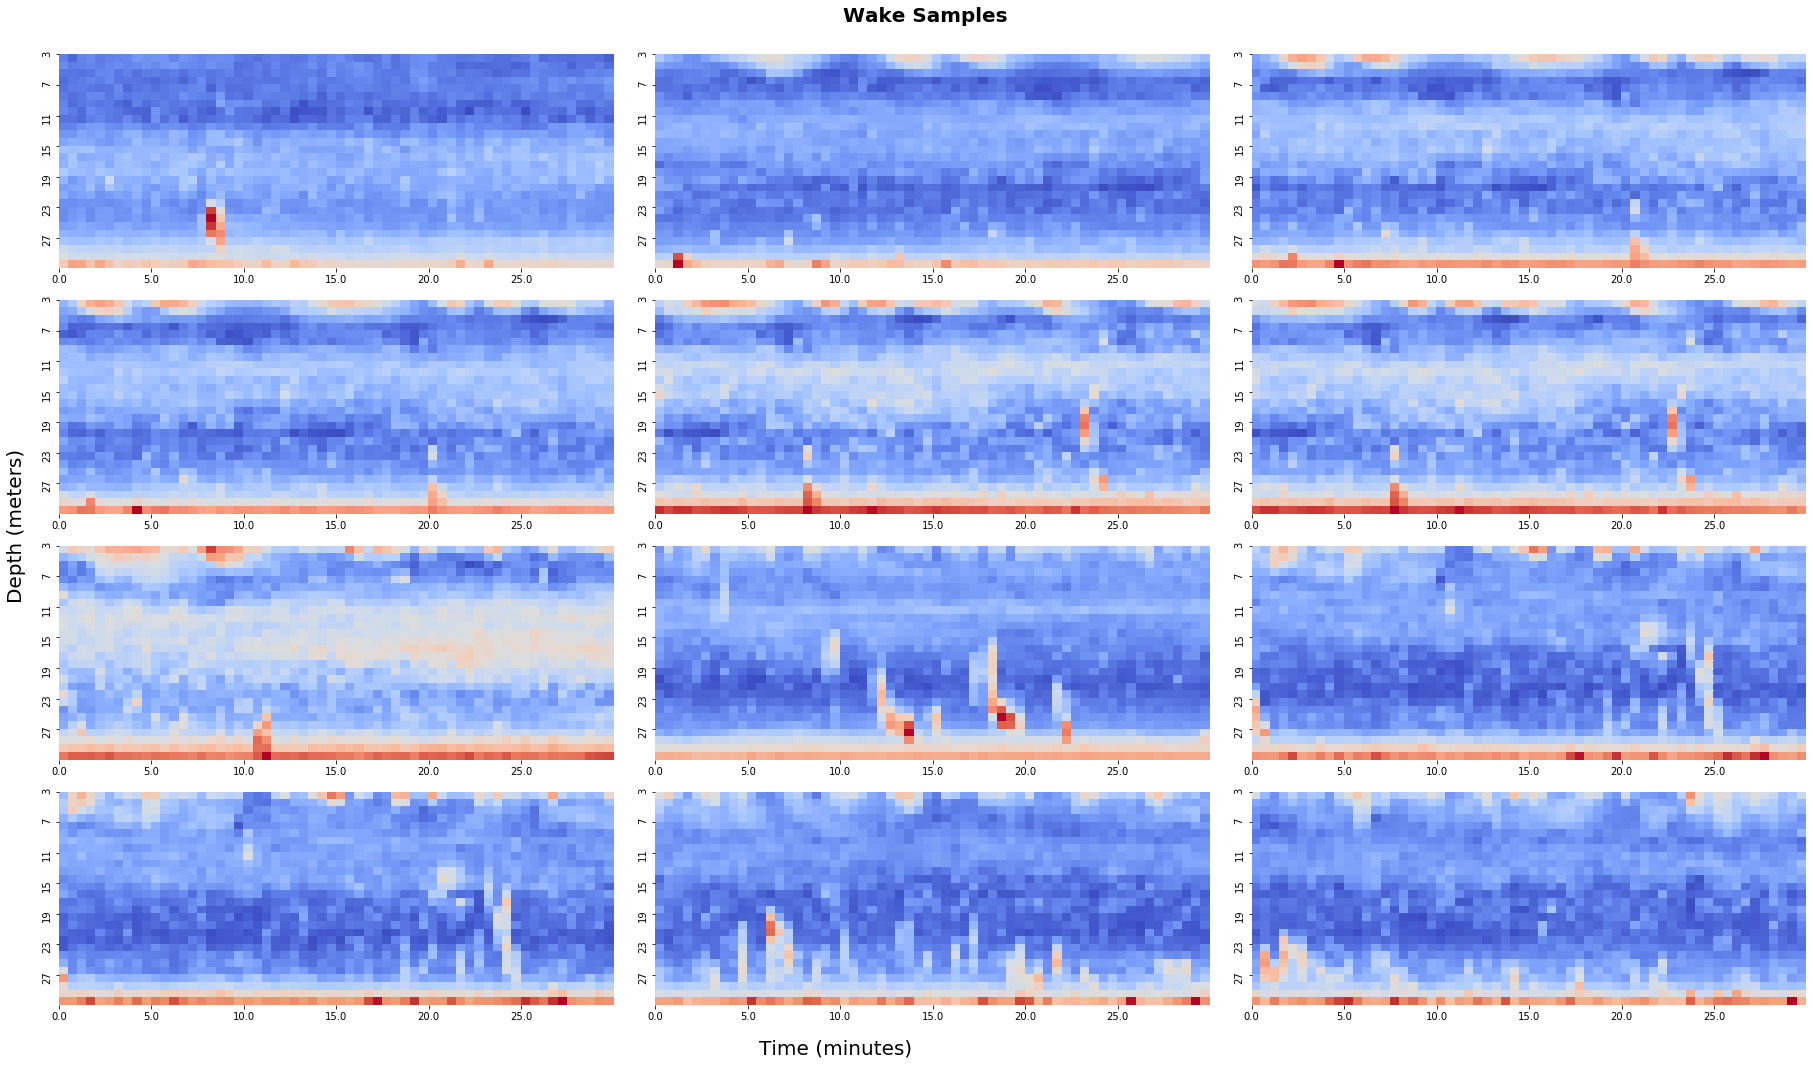

In [207]:
wp.make_12_heatmaps(predicted_wakes[:12, 3, :-1,:])

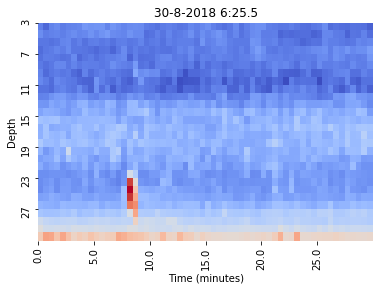

In [210]:
wp.make_heatmap(predicted_wakes[0, 3, :-1,:], predicted_wakes[0, 3,-1,:])

In [221]:
days = []
for uw in unknown_wakes_day:
    days.append(wp.stamp_to_date(uw)[1])

In [222]:
d_count = dict(Counter(days)) # Day: false negatives

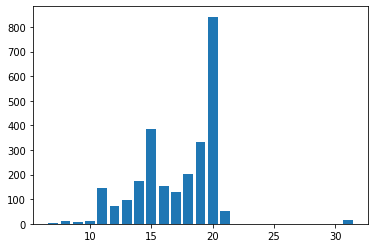

In [224]:
plt.bar(d_count.keys(), d_count.values())
plt.show()

In [225]:
days = []
for uw in unknown_wakes_day_night:
    days.append(wp.stamp_to_date(uw)[1])
d_count = dict(Counter(days)) # Day: false negatives

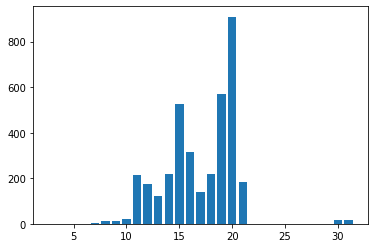

In [226]:
plt.bar(d_count.keys(), d_count.values())
plt.show()

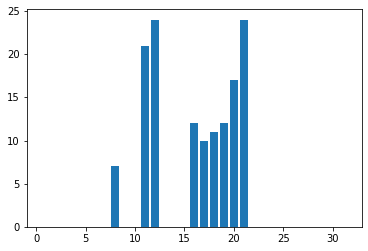

In [233]:
plt.bar(noise_distribution.keys(), noise_distribution.values())
plt.show()

Periods of noise according to the data description:
-	2018-09-08 07:00 – 2018-09-09 14:00
-	2018-09-11 07:00 - 2018-09-13 00:00  
-	2018-09-16 12:00 - 2018-09-17 10:00  
-	2018-09-18 08:00 - 2018-09-18 19:00  
-	2018-09-19 12:00 - 2018-09-20 17:00
-	2018-09-21 00:00 - 2018-09-23 10:00 


In [231]:
noise_distribution = { # Day: hours with noise according to data description
    8: 7,
    11: 21,
    12: 24,
    16: 12,
    17: 10,
    18: 11,
    19: 12,
    20: 17,
    21: 24,
    22: 0 #Cutoff
}

In [232]:
for i in [1, 2, 3, 4, 5, 6, 7, 9, 10, 13, 14, 15, 23, 24, 25, 26, 27, 28, 29, 30, 31]:
    noise_distribution[i] = 0